In [1]:
import pandas as pd
import torch.utils.data as Data
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn import init
import matplotlib.pyplot as plt
from torch import nn

In [111]:
HIDDEN_LAYERS = 3
B_INIT = -0.2
ACTIVATION = F.relu
class FcNet(torch.nn.Module):
    def __init__(self, num_features, dim_out, batch_normalization=True):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(FcNet, self).__init__()
        self.do_bn = batch_normalization
        self.fcs = []
        self.bns = []
        self.bn_input = nn.BatchNorm1d(num_features, momentum=0.5)   # for input data
        
        for i in range(HIDDEN_LAYERS):
            input_size = num_features if i == 0 else 10 # each hidden layer has 10 neurons
            fc = nn.Linear(input_size, 10)
            setattr(self, 'fc%i' % i, fc) # such that pytorch can distinguish different layers
            self._set_init(fc)
            self.fcs.append(fc)
            if self.do_bn:
                bn = nn.BatchNorm1d(10, momentum=0.5)
                setattr(self, 'bn%i' % i, bn)
                self.bns.append(bn)
            
        self.predict = nn.Linear(10, 1)
        self._set_init(self.predict)
    
    def _set_init(self, layer):
        init.normal(layer.weight, mean=0, std=0.1)
        init.constant(layer.bias, B_INIT)

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        pre_activation = [x]
        if self.do_bn: x = self.bn_input(x)
        layer_input = [x]
        for i in range(HIDDEN_LAYERS):
            x = self.fcs[i](x)
            pre_activation.append(x)
            if self.do_bn:
                x = self.bns[i](x)
            x = ACTIVATION(x)
            layer_input.append(x)
        out = self.predict(x)
        return out, layer_input, pre_activation

In [112]:
df = pd.read_csv('Route15_trainMd.csv', index_col=0)

In [113]:
df['TT_prv2'] = df['TT'].shift(2)
df['TT_prv3'] = df['TT'].shift(3)
df['flow_prv3'] = df['flow'].shift(3)

In [114]:
drop_columns = ['Closed2','Closed3','Closed4','Closed5','Ramp0','Ramp1','Ramp2','Ramp3','Ramp4','Ramp5',
                'Evt4','Evt5','Lanes0','Lanes1','Lanes2','Lanes3','Lanes4','Lanes5','Closed0','Closed1',
                'SpdTrnd3','density3','SpdTrnd4','density4','SpdTrnd5','density5','Evt0','Evt1','Evt2','Evt3',
                'FT5','flow5','occ5','lanes5','SpdTrnd0','density0','SpdTrnd1','density1','SpdTrnd2','density2',
                'SpdLast4','JT4','FT4','flow4','occ4','lanes4','Spd5','SpdAvg5','SpdLast5','JT5',
                'Spd3','SpdAvg3','SpdLast3','JT3','FT3','flow3','occ3','lanes3','Spd4','SpdAvg4',
                'occ1','lanes1','Spd2','SpdAvg2','SpdLast2','JT2','FT2','flow2','occ2','lanes2',
                'FT0','flow0','occ0','lanes0','Spd1','SpdAvg1','SpdLast1','JT1','FT1','flow1',
                'Spd0','SpdAvg0','SpdLast0','JT0','TT_nxt3','TT_nxt6','TT_nxt12','W_TT','S_TT','L_TT','TT_chng1',
                'TT_mean','flow_mean','flow_chng1','flow_chng2']
keep_columns = ['TT','flow','sVF','bVF','month','holiday','hldy_seq','weekday','timeslot',
                'TT_prv1','TT_prv2','TT_prv3','TT_dev',
                'flow_dev','flow_prv1','flow_prv2','flow_prv3']

train_df = df[keep_columns]

In [115]:
target = pd.DataFrame(train_df['TT'])
target['TT_30min_later'] = target['TT'].shift(periods = -6) # 30min
target['TT_60min_later'] = target['TT'].shift(periods = -12) # 60min

x_train, x_val, x_test = train_df[:-17568].fillna(-1), train_df[-17568:-8928].fillna(-1), train_df[-8928:].fillna(-1)
y_train, y_val, y_test = target[:-17568]['TT_30min_later'].fillna(-1), target[-17568:-8928]['TT_30min_later'].fillna(-1), target[-8928:]['TT_30min_later'].fillna(-1)

x_size = x_train.shape[1]
y_size = 1 # for regression
batch_size = 64
x_train, y_train = torch.from_numpy(x_train.values).float(), torch.from_numpy(y_train.values).float()
x_val, y_val = Variable(torch.from_numpy(x_val.values).float()).cuda(), Variable(torch.from_numpy(y_val.values).float()).cuda()

train_dataset = Data.TensorDataset(data_tensor=x_train, target_tensor=y_train)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2,)

In [117]:
def mape_loss(predict, target):
    import numpy
    assert ((type(predict) == type(target) == torch.autograd.variable.Variable) or
            type(predict) == type(target) == numpy.ndarray), 'check the type of inputs, they have to be all torch Variable or numpy ndarray'
    if type(predict) == type(target) == torch.autograd.variable.Variable:
        loss = (1 / predict.shape[0] * 
               torch.mean((target - predict).abs() / target))
    elif type(predict) == type(target) == numpy.ndarray:
        loss = (1 / predict.shape[0] * 
               numpy.mean(numpy.abs(target.flatten() - predict.flatten()) / target))        
    return loss

In [118]:
epoch = 100
model = FcNet(x_size, y_size)
model.cuda() # using gpu

#loss_func = torch.nn.MSELoss()
loss_func = mape_loss
#optimizer = torch.optim.SGD(model.parameters(), lr=0.03)
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

for t in range(epoch):  
    for step, (b_x, b_y) in enumerate(train_loader):
        b_x, b_y = Variable(b_x).type(torch.FloatTensor).cuda(), Variable(b_y).type(torch.FloatTensor).cuda()
        pred, _, _ = model(b_x)
        loss = loss_func(pred, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    y_val_predict, _, _ = model(x_val)
    print(str(t+1))
    print('training error:', loss.data[0])
    print('validation error:', loss_func(y_val_predict, y_val).data[0])
    

1
training error: 0.0005618996801786125
validation error: 8.450171662843786e-06
2
training error: 0.0007474606391042471
validation error: 8.472297849948518e-06
3
training error: 0.0005409382283687592
validation error: 8.416929631493986e-06
4
training error: 0.0007356734713539481
validation error: 8.387803063669708e-06
5
training error: 0.0007500201463699341
validation error: 8.397903002332896e-06
6
training error: 0.0007994102779775858
validation error: 8.440033525403123e-06
7
training error: 0.000809063611086458
validation error: 8.41178643895546e-06
8
training error: 0.0007284981547854841
validation error: 8.479022653773427e-06
9
training error: 0.0005632519023492932
validation error: 8.544962838641368e-06
10
training error: 0.0009561191545799375
validation error: 8.516674824932124e-06
11
training error: 0.0007349964580498636
validation error: 8.409194379055407e-06
12
training error: 0.0008289343677461147
validation error: 8.430004527326673e-06
13
training error: 0.000733454478904604

In [75]:
import matplotlib.pyplot as plt
predict = model(Variable(x_train).type(torch.FloatTensor).cuda())[0].type(torch.FloatTensor).data.numpy()
ground_truth = y_train.numpy()

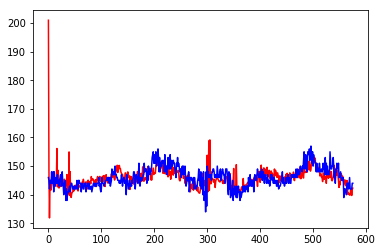

In [76]:
x = range(288*2)
plt.plot(x, predict[:288*2], 'r', x, ground_truth[:288*2], 'b')
plt.show()

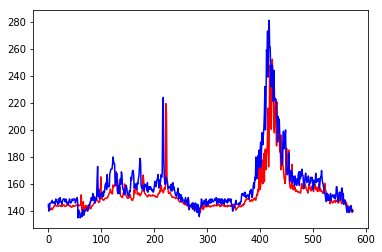

In [77]:
val_predict = model(x_val.type(torch.FloatTensor).cuda())[0].type(torch.FloatTensor).data.numpy()
val_ground_truth = y_val.type(torch.FloatTensor).data.numpy()
plt.plot(x, val_predict, 'r', x, val_ground_truth, 'b')
plt.show()

In [80]:
type(ground_truth)

numpy.ndarray

In [79]:
type(predict)

numpy.ndarray

In [106]:
mape_loss(predict, ground_truth)

1.48005289621379e-07

In [107]:
mape_loss(val_predict, val_ground_truth)

6.1291933956521531e-06

In [92]:
import numpy as np

nan